In [1]:
import matplotlib.pyplot as plt 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns

In [4]:
import cv2

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from tqdm import tqdm
import os
from sklearn.utils import shuffle


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from tensorflow.keras.applications import EfficientNetB0

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
import io

In [13]:
from PIL import Image

In [14]:
from IPython.display import display, clear_output

## Basic set up

In [15]:
labels = ['glioma_tumor', 'no_tumor','meningioma_tumor','pituitary_tumor']

In [16]:

X_train = []
y_train = []
os.getcwd()
os.chdir('/content/drive/MyDrive')


In [17]:
#scaling our images to 150px by 150px to make training easier/convenient
scaleDown = 150
#these 2 for loops are horrendous i know, i can't be bothered to make them more elegant, sorry
for i in labels: 
    folderPath = os.path.join('Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (scaleDown, scaleDown))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (scaleDown, scaleDown))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 100.00it/s]


In [18]:
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [19]:
X_train.shape

(3264, 150, 150, 3)

In [ ]:
#The (3002, 150, 150, 3) is the final shape of our training data (the 3002 images that have been scaled to
# 150x150px with 3 channels and converted to an np array)

### Splitting the Data into Training and Testing

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.08, random_state=101)

### Converting the text based values of the y_train array into numerical values

In [21]:
y_train_final = []
for i in y_train:
    y_train_final.append(labels.index(i))
y_train = y_train_final
y_train = tf.keras.utils.to_categorical(y_train)


y_test_final = []
for i in y_test:
    y_test_final.append(labels.index(i))
y_test = y_test_final
y_test = tf.keras.utils.to_categorical(y_test)


In [22]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(scaleDown, scaleDown,3))

In [23]:
model = effnet.output

In [24]:
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
# model.summary() to get a useful summary about our model

In [25]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [26]:
#callbacks
tensorboard = TensorBoard(log_dir = 'logs')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='training1.chkpt',save_weights_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)

In [40]:
## Loading the saved weights from out trained model to avoid re-training
checkpoint_path = "checkpoint/training1.chkpt"
model.load_weights(checkpoint_path)



In [41]:
##Evaluate the model after loading the weights
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

9/9 - 9s - loss: 0.1244 - accuracy: 0.9656 - 9s/epoch - 953ms/step
Restored model, accuracy: 96.56%


In [42]:
##Training the model (Leaning Step)
history = model.fit(X_train,y_train,validation_split=0.08, epochs=12, verbose=1, batch_size=40, callbacks=[tensorboard, cp_callback,reduce_lr])

Epoch 1/12


KeyboardInterrupt: ignored

In [ ]:
#model.save('saved_model/my_model')


TypeError: ignored

In [ ]:
pred = model.predict(X_test)

9/9 [==============================] - 8s 669ms/step


In [ ]:
pred = np.argmax(pred,axis=1)

In [ ]:
y_test_final = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_test_final,pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        72
           1       0.98      1.00      0.99        41
           2       0.94      0.96      0.95        83
           3       0.99      1.00      0.99        66

    accuracy                           0.97       262
   macro avg       0.97      0.97      0.97       262
weighted avg       0.97      0.97      0.97       262



## Loading a new image and making a prediction using our model

1/1 [==============================] - 0s 80ms/step
The Model predicts : Pituitary Tumor


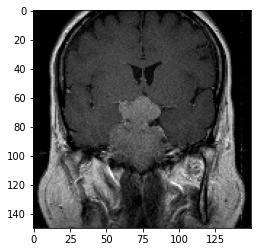

In [47]:
img = Image.open(r"ImagesForPrediction/ls44dcxet1487oinyhhiqas13d5f.jpg")
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(opencvImage, (150,150))
plt.imshow(img)
img = img.reshape(1,150,150,3)
prediction = model.predict(img)
prediction = np.argmax(prediction,axis=1)[0]
    
    
if prediction==0:
    prediction='Glioma'
elif prediction==1:
    prediction='No Tumor'
elif prediction==2:
        prediction='Meningioma'
elif prediction==3:
    prediction='Pituitary Tumor'
    
print(f'The Model predicts : {prediction}')    

In [ ]:
#@title Loading saved modules 

# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

# Check its accuracy
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


In [ ]:
os.getcwd()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-48-a78b1fb2bab9>", line 1, in <module>
    os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/ultratb

OSError: ignored